In [1]:
from src.functions import *

# Global setting
with open(projectdir+'setting.json', 'r') as f:
    setting = json.load(f)
    _gamma = setting["gamma"]
    _T = setting["T"]
    _t = setting["t"]
    _num_random_models = setting["num_random_models"]

# Load the JSON file
with open(projectdir+'instances.json', 'r') as f:
    instances = json.load(f)

In [2]:
n = 8

In [3]:
# NOTE: We evaluate the algorithm on the SAME 100 random instances for each grid point

# Grid search

In [4]:
gamma_lims = (0,1) 
gamma_steps = 48
time_lims = (0,30) 
time_steps = 48

gamma_range = np.linspace(gamma_lims[0], gamma_lims[1], gamma_steps)
time_range = np.linspace(time_lims[0], time_lims[1], time_steps)

def f_1(t):
    '''
    Calculate spectral gaps for quantum proposal.
    f_1(t) is defined to parallelize the time-loop.
    '''    
    delta_quantum_arr = np.zeros((gamma_steps, _num_random_models))
    
    for gamma_id, gamma in enumerate(gamma_range):
        for i, instance in enumerate(instances[f'{n}']):
            m = IsingModel.from_coefficients(n, instance)
            # Calculate delta for quantum proposal
            proposal_mat_quantum = get_proposal_mat_quantum(m, gamma, t)
            P_quantum = get_transition_matrix(m, _T, proposal_mat_quantum)
            delta_quantum = get_delta(P_quantum)
            delta_quantum_arr[gamma_id, i] = delta_quantum

    return delta_quantum_arr

In [5]:
sweep_data = np.asarray(joblib.Parallel(n_jobs=-1)(joblib.delayed(f_1)(t) for t in tqdm(time_range)))
sweep_data = sweep_data.swapaxes(0,1)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [00:00<00:00, 123.35it/s]

100%|██████████| 48/48 [00:00<00:00, 107.46it/s]

In [6]:
delta_quantum_arr = sweep_data

# Save the data

In [7]:
grid_search = {'delta': delta_quantum_arr.tolist(),
               'num_random_models': _num_random_models,
               'gamma_range': gamma_range.tolist(),
               'time_range': time_range.tolist(),
               'T': _T,
               'n': n}

save_in_json(grid_search, f'data/grid_search_n{n}.json')

# Average and plot the results

In [8]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2, ddof=1)

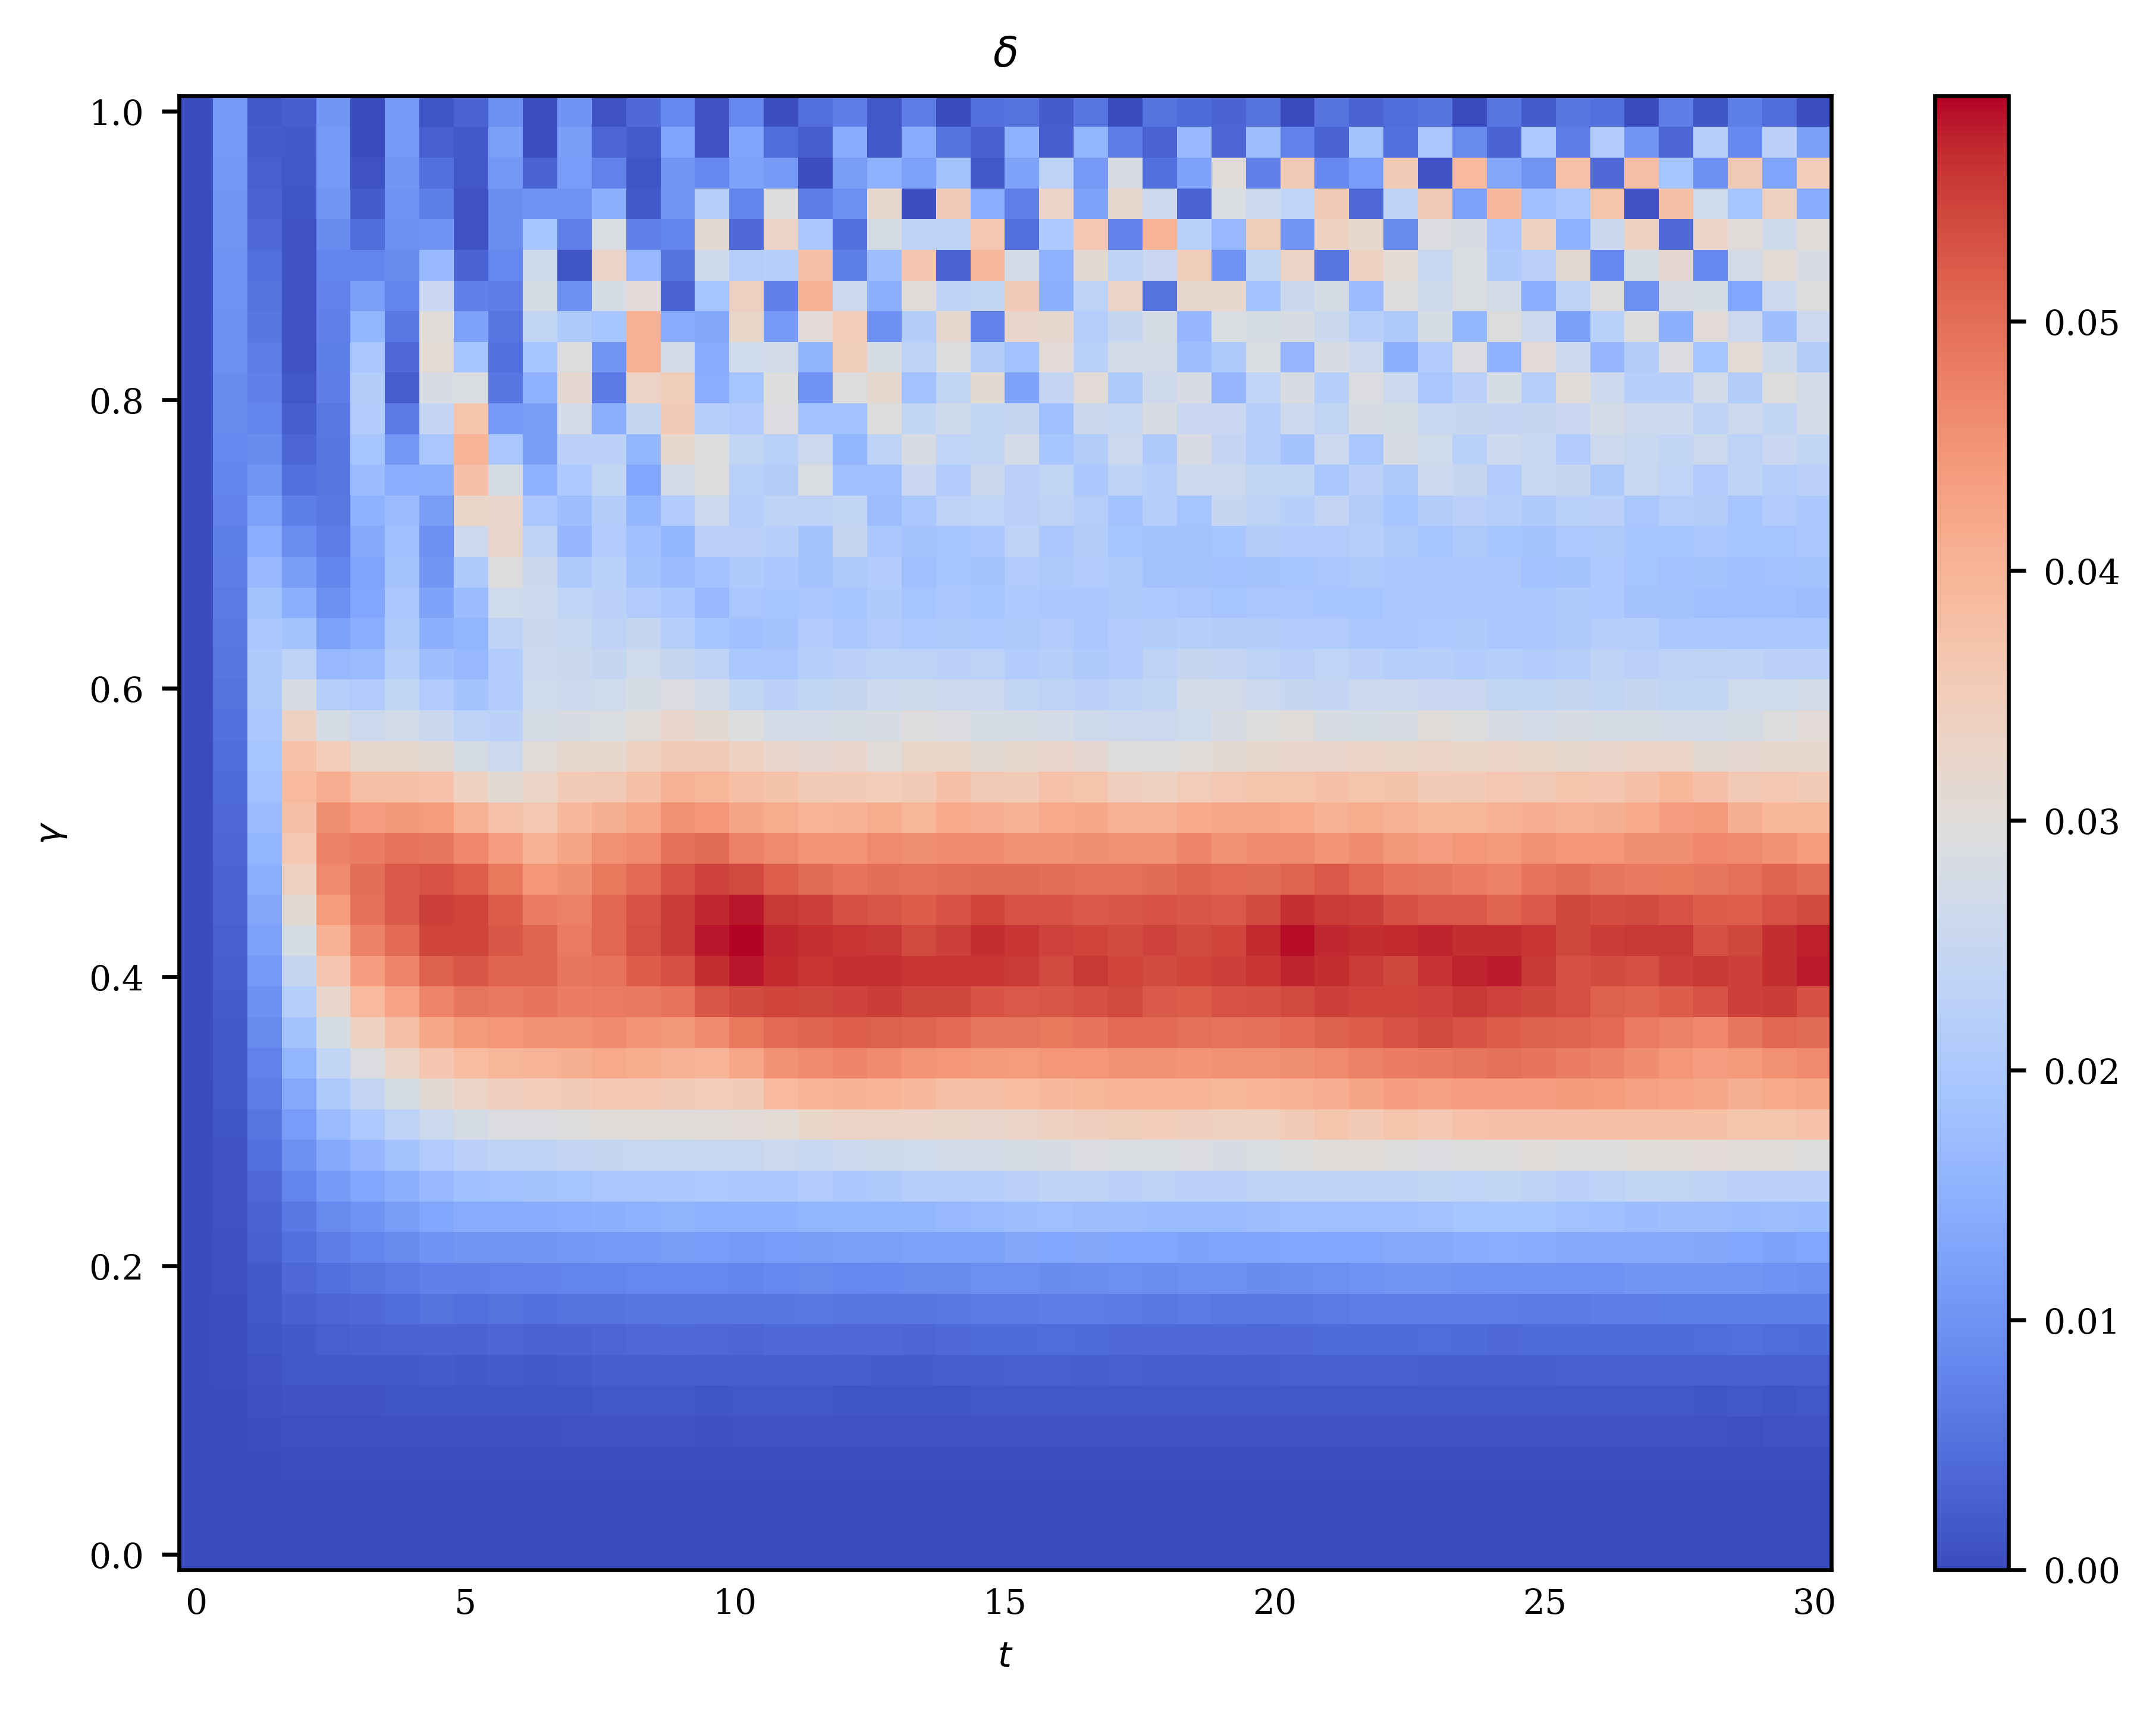

In [9]:
fig = plt.figure()

pc0 = plt.pcolor(time_range, 
                gamma_range,
                delta_quantum_arr_avg, 
                cmap='coolwarm',
                vmin=0,
                vmax=np.max(delta_quantum_arr_avg)
                )
fig.colorbar(pc0)

plt.xlabel('$t$')
plt.ylabel('$\gamma$')
plt.title('$\delta$')

fig.tight_layout()

# fig.savefig(local_path+f'figures/grid_search_n{n}')